In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
from zimp.readability.winnetka import PrepositionFrequencyScore, PosMethod
from glob import glob

plt.style.use('seaborn-whitegrid')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package perluniprops to
[nltk_data]     C:\Users\Martin\AppData\Roaming\nltk_data...
[nltk_data]   Package perluniprops is already up-to-date!


In [2]:
source_dir = '../../zimp_orchestrator/orch/resources'
files = {}
for ds_path in glob(source_dir + '/*'):
    if not os.path.isdir(ds_path):
        continue
    ds_name = os.path.basename(ds_path)
    files[ds_name] = [os.path.join(ds_path, 'train.csv'), os.path.join(ds_path, 'test.csv')]

In [3]:
def get_scores(paths, r_metric, track_name):
    texts = pd.read_csv(paths[0]).text.append(pd.read_csv(paths[1]).text)
    s = pd.Series(r_metric.get_scores(texts), name=track_name)
    return s

def get_ds_language(track):
    if track in ['10K-GNAD', 'GERMEVAL-2018', 'GERMEVAL-2020']:
        return 'german'
    return 'english'

In [52]:
dfs = []
for dataset in files.keys():
    print(f'Analyzing {dataset}...')
    path = f'pf_score/{dataset}_spacy.csv'
    if os.path.exists(path):
        s = pd.read_csv(path)[dataset+'_spacy']
    else:
        s = get_scores(files[dataset], PrepositionFrequencyScore(language=get_ds_language(dataset), pos_method=PosMethod.SPACY), f'{dataset}_spacy')
        s.to_csv(path, index=False)
    dfs.append(s)
    
    path = f'pf_score/{dataset}_stanza.csv'
    if os.path.exists(path):
        s = pd.read_csv(path)[dataset+'_stanza']
    else:
        s = get_scores(files[dataset], PrepositionFrequencyScore(language=get_ds_language(dataset), pos_method=PosMethod.STANZA), f'{dataset}_stanza')
        s.to_csv(path, index=False)
    dfs.append(s)

df = pd.concat(dfs, axis=1)
df_rel = df/df.sum(axis=0)
df_rel

Analyzing 10K-GNAD...


2022-06-26 19:58:32 INFO: Downloading default packages for language: de (German)...
2022-06-26 19:58:35 INFO: File exists: C:\Users\Martin\stanza_resources\de\default.zip
2022-06-26 19:58:40 INFO: Finished downloading models and saved to C:\Users\Martin\stanza_resources.


2022-06-26 19:58:40 WARNING: Language de package default expects mwt, which has been added
2022-06-26 19:58:41 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |

2022-06-26 19:58:41 INFO: Use device: cpu
2022-06-26 19:58:41 INFO: Loading: tokenize
2022-06-26 19:58:41 INFO: Loading: mwt
2022-06-26 19:58:41 INFO: Loading: pos
2022-06-26 19:58:41 INFO: Done loading processors!

KeyboardInterrupt



In [5]:
df.columns

Index(['TREC-6_spacy', 'TREC-6_stanza'], dtype='object')

<AxesSubplot:xlabel='TREC-6_spacy', ylabel='TREC-6_stanza'>

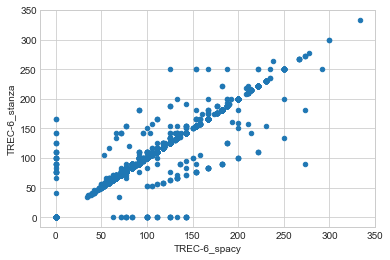

In [51]:
df.plot(kind='scatter', x='TREC-6_spacy', y='TREC-6_stanza')

In [7]:
df['TREC-6_spacy'].corr(df['TREC-6_stanza'])

0.974554534016028

In [21]:
idxs = (df['TREC-6_spacy'] - df['TREC-6_stanza']).sort_values()
idxs[idxs.index < 5000]

1089   -166.666667
100    -166.666667
4912   -142.857143
3171   -142.857143
4856   -125.000000
           ...    
4082    142.857143
4854    142.857143
2997    142.857143
2237    142.857143
3848    181.818182
Length: 5000, dtype: float64

In [10]:
txts = pd.read_csv(files['TREC-6'][0]).text

In [29]:
txts.loc[2237]

'What river is Pocahontas buried along ?'

### English qualitative analysis

In [9]:
spacy_model = PrepositionFrequencyScore(language='english', pos_method=PosMethod.SPACY).prep_extractor.base_model
stanza_model = PrepositionFrequencyScore(language='english', pos_method=PosMethod.STANZA).prep_extractor.base_model

def qual_analysis(txt):
    sp_toks = spacy_model(txt)
    st_toks = [w for s in stanza_model(txt).sentences for w in s.words]
    print('SPACY:', [t.text + '--' + t.pos_ for t in sp_toks])
    print('STANZA:', [t.text + '--' + t.upos for t in st_toks])

2022-06-26 18:28:25 INFO: Downloading default packages for language: en (English)...
2022-06-26 18:28:26 INFO: File exists: C:\Users\Martin\stanza_resources\en\default.zip
2022-06-26 18:28:31 INFO: Finished downloading models and saved to C:\Users\Martin\stanza_resources.


2022-06-26 18:28:31 INFO: Loading these models for language: en (English):
| Processor | Package  |
------------------------
| tokenize  | combined |
| pos       | combined |

2022-06-26 18:28:31 INFO: Use device: cpu
2022-06-26 18:28:31 INFO: Loading: tokenize
2022-06-26 18:28:31 INFO: Loading: pos
2022-06-26 18:28:31 INFO: Done loading processors!


In [33]:
qual_analysis('What generation am I in ?')
# stanza right

SPACY: ['What--DET', 'generation--NOUN', 'am--AUX', 'I--PRON', 'in--ADV', '?--PUNCT']
STANZA: ['What--DET', 'generation--NOUN', 'am--AUX', 'I--PRON', 'in--ADP', '?--PUNCT']


In [14]:
qual_analysis('Who invented Make-up ?')
# spacy right

SPACY: ['Who--PRON', 'invented--VERB', 'Make--PROPN', '---PUNCT', 'up--NOUN', '?--PUNCT']
STANZA: ['Who--PRON', 'invented--VERB', 'Make--VERB', '---PUNCT', 'up--ADP', '?--PUNCT']


In [35]:
qual_analysis('Who loved Flash Gordon besides Dale?')
# stanza right?

SPACY: ['Who--PRON', 'loved--VERB', 'Flash--PROPN', 'Gordon--PROPN', 'besides--SCONJ', 'Dale--PROPN', '?--PUNCT']
STANZA: ['Who--PRON', 'loved--VERB', 'Flash--PROPN', 'Gordon--PROPN', 'besides--ADP', 'Dale--PROPN', '?--PUNCT']


In [36]:
qual_analysis('What happens to used motor oil?')
# spacy right? 

SPACY: ['What--PRON', 'happens--VERB', 'to--PART', 'used--VERB', 'motor--NOUN', 'oil--NOUN', '?--PUNCT']
STANZA: ['What--PRON', 'happens--VERB', 'to--ADP', 'used--VERB', 'motor--NOUN', 'oil--NOUN', '?--PUNCT']


In [39]:
qual_analysis('Why do airliners crash vs. gliding down ?')
# stanza right

SPACY: ['Why--SCONJ', 'do--AUX', 'airliners--VERB', 'crash--VERB', 'vs.--ADP', 'gliding--VERB', 'down--ADV', '?--PUNCT']
STANZA: ['Why--ADV', 'do--AUX', 'airliners--NOUN', 'crash--VERB', 'vs.--ADP', 'gliding--VERB', 'down--ADP', '?--PUNCT']


In [41]:
qual_analysis('What is a fear of sinning?')

SPACY: ['What--PRON', 'is--AUX', 'a--DET', 'fear--NOUN', 'of--ADP', 'sinning--VERB', '?--PUNCT']
STANZA: ['What--PRON', 'is--AUX', 'a--DET', 'fear--NOUN', 'of--SCONJ', 'sinning--VERB', '?--PUNCT']


In [42]:
qual_analysis('What can be done about snoring?')

SPACY: ['What--PRON', 'can--AUX', 'be--AUX', 'done--VERB', 'about--ADP', 'snoring--VERB', '?--PUNCT']
STANZA: ['What--PRON', 'can--AUX', 'be--AUX', 'done--VERB', 'about--SCONJ', 'snoring--VERB', '?--PUNCT']


In [43]:
qual_analysis('What river is Pocahontas buried along?')

SPACY: ['What--DET', 'river--NOUN', 'is--AUX', 'Pocahontas--PROPN', 'buried--VERB', 'along--ADP', '?--PUNCT']
STANZA: ['What--DET', 'river--NOUN', 'is--AUX', 'Pocahontas--PROPN', 'buried--VERB', 'along--ADV', '?--PUNCT']


### German qualitative analysis 

In [45]:
spacy_model = PrepositionFrequencyScore(language='german', pos_method=PosMethod.SPACY).prep_extractor.base_model
stanza_model = PrepositionFrequencyScore(language='german', pos_method=PosMethod.STANZA).prep_extractor.base_model

def qual_analysis(txt):
    sp_toks = spacy_model(txt)
    st_toks = [w for s in stanza_model(txt).sentences for w in s.words]
    print('SPACY:', [t.text + '--' + t.pos_ for t in sp_toks])
    print('STANZA:', [t.text + '--' + t.upos for t in st_toks])

2022-06-26 19:40:50 INFO: Downloading default packages for language: de (German)...
2022-06-26 19:40:53 INFO: File exists: C:\Users\Martin\stanza_resources\de\default.zip
2022-06-26 19:40:58 INFO: Finished downloading models and saved to C:\Users\Martin\stanza_resources.


2022-06-26 19:40:59 WARNING: Language de package default expects mwt, which has been added
2022-06-26 19:40:59 INFO: Loading these models for language: de (German):
| Processor | Package |
-----------------------
| tokenize  | gsd     |
| mwt       | gsd     |
| pos       | gsd     |

2022-06-26 19:40:59 INFO: Use device: cpu
2022-06-26 19:40:59 INFO: Loading: tokenize
2022-06-26 19:40:59 INFO: Loading: mwt
2022-06-26 19:40:59 INFO: Loading: pos
2022-06-26 19:40:59 INFO: Done loading processors!


In [27]:
qual_analysis('@SKoerzell Gratuliere ihm herzlich von mit!')
# stanza misclassifies 'mit' as adv

SPACY: ['@SKoerzell--PROPN', 'Gratuliere--NOUN', 'ihm--PRON', 'herzlich--ADV', 'von--ADP', 'mit--ADV', '!--PUNCT']
STANZA: ['@SKoerzell--PROPN', 'Gratuliere--VERB', 'ihm--PRON', 'herzlich--ADJ', 'von--ADP', 'mit--ADP', '!--PUNCT']


In [28]:
qual_analysis('@Dagobert95 Das Badnerlied ist am besten!')
# stanza misclassifies 'am besten'

SPACY: ['@Dagobert95--NOUN', 'Das--DET', 'Badnerlied--NOUN', 'ist--AUX', 'am--PART', 'besten--ADV', '!--PUNCT']
STANZA: ['@Dagobert95--NUM', 'Das--DET', 'Badnerlied--NOUN', 'ist--AUX', 'an--ADP', 'dem--DET', 'besten--ADJ', '!--PUNCT']


In [46]:
qual_analysis('US-Experte sagt Deutschlands Untergang voraus')
# stanza correctly classifies 'voraus' as adverb

SPACY: ['US-Experte--NOUN', 'sagt--VERB', 'Deutschlands--PROPN', 'Untergang--NOUN', 'voraus--ADP']
STANZA: ['US--PROPN', '---PUNCT', 'Experte--NOUN', 'sagt--VERB', 'Deutschlands--PROPN', 'Untergang--NOUN', 'voraus--ADV']


In [30]:
qual_analysis('Doitsche kauft nicht bai Türken')
# spacy correctly classifies as ADP

SPACY: ['Doitsche--NOUN', 'kauft--VERB', 'nicht--PART', 'bai--ADP', 'Türken--NOUN']
STANZA: ['Doitsche--NOUN', 'kauft--VERB', 'nicht--PART', 'bai--ADJ', 'Türken--NOUN']


In [47]:
qual_analysis('@lizvlx @msulzbacher Weshalb? Antisemitismus, der sich auf auf Israel bezieht ist nach wie vor Antisemitismus')
# both wron?? adverb?

SPACY: ['Antisemitismus--NOUN', ',--PUNCT', 'der--PRON', 'sich--PRON', 'auf--ADP', 'auf--ADP', 'Israel--PROPN', 'bezieht--VERB', 'ist--AUX', 'nach--ADV', 'wie--CCONJ', 'vor--ADP', 'Antisemitismus--NOUN']
STANZA: ['Antisemitismus--NOUN', ',--PUNCT', 'der--PRON', 'sich--PRON', 'auf--ADP', 'auf--ADP', 'Israel--PROPN', 'bezieht--VERB', 'ist--AUX', 'nach--ADP', 'wie--ADP', 'vor--ADP', 'Antisemitismus--NOUN']


In [49]:
qual_analysis('Wohl zu viel Weihwasser gesoffen.')
# spacy feels right?

SPACY: ['Wohl--ADV', 'zu--PART', 'viel--DET', 'Weihwasser--NOUN', 'gesoffen--VERB', '.--PUNCT']
STANZA: ['Wohl--ADV', 'zu--ADP', 'viel--PRON', 'Weihwasser--NOUN', 'gesoffen--VERB', '.--PUNCT']


In [50]:
qual_analysis('@BILD Gut gemacht Mr Präsident 👍👍')
# spacy is wrong

SPACY: ['@BILD--NOUN', 'Gut--NOUN', 'gemacht--VERB', 'Mr--ADP', 'Präsident--NOUN', '👍--NOUN', '👍--NOUN']
STANZA: ['@BILD--PROPN', 'Gut--PROPN', 'gemacht--VERB', 'Mr--PROPN', 'Präsident--NOUN', '👍👍--PUNCT']


In [52]:
qual_analysis('@drumheadberlin @MatthiasLE45 @China_Welt_News Ich bin 60 u. solche Typen sind f. mich das ALLERLETZTE, leider aber typisch f. unsere Medien')
# spacy correct with f. but wrong with u.

SPACY: ['@drumheadberlin--PROPN', '@MatthiasLE45--PROPN', '@China_Welt_News--PROPN', 'Ich--PRON', 'bin--AUX', '60--NUM', 'u.--ADP', 'solche--DET', 'Typen--NOUN', 'sind--AUX', 'f.--ADP', 'mich--PRON', 'das--DET', 'ALLERLETZTE--PROPN', ',--PUNCT', 'leider--ADV', 'aber--ADV', 'typisch--ADV', 'f.--ADP', 'unsere--DET', 'Medien--NOUN']
STANZA: ['@drumheadberlin--ADJ', '@--X', 'MatthiasLE45--PROPN', '@China--PROPN', '_Welt--PROPN', '_News--PROPN', 'Ich--PRON', 'bin--AUX', '60--NUM', 'u--NOUN', '.--PUNCT', 'solche--PRON', 'Typen--NOUN', 'sind--AUX', 'f.--VERB', 'mich--PRON', 'das--DET', 'ALLERLETZTE--NOUN', ',--PUNCT', 'leider--ADV', 'aber--CCONJ', 'typisch--ADV', 'f.--ADV', 'unsere--DET', 'Medien--NOUN']


In [54]:
qual_analysis('@66Freedom66 Stoppt denn keiner diese Dummbacke!')
# spacy wrong

SPACY: ['@66Freedom66--ADP', 'Stoppt--PROPN', 'denn--ADV', 'keiner--PRON', 'diese--DET', 'Dummbacke--NOUN', '!--PUNCT']
STANZA: ['@66Freedom66--NUM', 'Stoppt--VERB', 'denn--ADV', 'keiner--PRON', 'diese--PRON', 'Dummbacke--NOUN', '!--PUNCT']
